In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

In [86]:
df_raw = pd.read_pickle("../data/EUR_USD_H1.pkl")

In [87]:
df_raw.shape

(37219, 14)

In [88]:
df_an = df_raw.copy() # df_raw.iloc[-6000:].copy()
df_an.reset_index(drop=True, inplace=True)

In [89]:
df_an.shape

(37219, 14)

In [90]:
df_an = RSI(df_an)

In [91]:
df_an.tail()

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,RSI_14
37214,2021-12-30 19:00:00+00:00,1063,1.13058,1.13298,1.13043,1.13274,1.13052,1.13291,1.13036,1.13267,1.13065,1.13306,1.13049,1.13280,51.407635
37215,2021-12-30 20:00:00+00:00,1092,1.13272,1.13304,1.13185,1.13193,1.13264,1.13297,1.13177,1.13186,1.13279,1.13311,1.13192,1.13200,48.671929
37216,2021-12-30 21:00:00+00:00,388,1.13195,1.13276,1.13194,1.13258,1.13188,1.13269,1.13187,1.13249,1.13202,1.13283,1.13201,1.13267,50.928675
37217,2021-12-30 22:00:00+00:00,118,1.13252,1.13264,1.13222,1.13230,1.13204,1.13236,1.13182,1.13218,1.13299,1.13299,1.13236,1.13243,49.910668
37218,2021-12-30 23:00:00+00:00,507,1.13227,1.13258,1.13190,1.13224,1.13214,1.13251,1.13183,1.13216,1.13240,1.13266,1.13198,1.13231,49.681497


In [92]:
df_an = apply_patterns(df_an)

In [93]:
df_an['EMA_200'] = df_an.mid_c.ewm(span=200, min_periods=200).mean()

In [94]:
df_an.columns

Index(['time', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h',
       'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'RSI_14',
       'body_lower', 'body_upper', 'body_bottom_perc', 'body_top_perc',
       'body_perc', 'direction', 'body_size', 'low_change', 'high_change',
       'body_size_change', 'mid_point', 'mid_point_prev_2', 'body_size_prev',
       'direction_prev', 'direction_prev_2', 'body_perc_prev',
       'body_perc_prev_2', 'HANGING_MAN', 'SHOOTING_STAR', 'SPINNING_TOP',
       'MARUBOZU', 'ENGULFING', 'TWEEZER_TOP', 'TWEEZER_BOTTOM',
       'MORNING_STAR', 'EVENING_STAR', 'EMA_200'],
      dtype='object')

In [95]:
our_cols = ['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 
            'ask_c', 'bid_c', 'ENGULFING', 'direction', 'EMA_200', 'RSI_14']

In [96]:
df_slim = df_an[our_cols].copy()
df_slim.dropna(inplace=True)
df_slim.reset_index(drop=True, inplace=True)

In [97]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14
0,2016-01-19 07:00:00+00:00,1.08736,1.08764,1.08595,1.08652,1.08660,1.08645,False,-1,1.088334,36.239350
1,2016-01-19 08:00:00+00:00,1.08654,1.08846,1.08636,1.08846,1.08861,1.08832,True,1,1.088336,47.615598
2,2016-01-19 09:00:00+00:00,1.08844,1.08890,1.08702,1.08724,1.08749,1.08699,False,-1,1.088323,42.482293
3,2016-01-19 10:00:00+00:00,1.08728,1.08834,1.08662,1.08730,1.08737,1.08722,False,1,1.088312,42.808846
4,2016-01-19 11:00:00+00:00,1.08728,1.08732,1.08599,1.08630,1.08637,1.08623,True,-1,1.088289,38.849941


In [98]:
BUY = 1
SELL = -1
NONE = 0
RSI_LIMIT = 50.0

def apply_signal(row):
    if row.ENGULFING == True:
        if row.direction == BUY and row.mid_l > row.EMA_200:
            if row.RSI_14 > RSI_LIMIT:
                return BUY
        if row.direction == SELL and row.mid_h < row.EMA_200:
            if row.RSI_14 < RSI_LIMIT:
                return SELL
    return NONE

In [99]:
df_slim["SIGNAL"] = df_slim.apply(apply_signal, axis=1)

In [100]:
df_slim["SIGNAL"].value_counts()

SIGNAL
 0    33779
-1     1635
 1     1606
Name: count, dtype: int64

In [101]:
LOSS_FACTOR = -1.0
PROFIT_FACTOR = 1.5

def apply_take_profit(row):
    if row.SIGNAL != NONE:
        return (row.mid_c - row.mid_o) * PROFIT_FACTOR + row.mid_c
    else:
        return 0.0

def apply_stop_loss(row):
    if row.SIGNAL != NONE:
        return row.mid_o
    else:
        return 0.0

In [102]:
df_slim["TP"] = df_slim.apply(apply_take_profit, axis=1)
df_slim["SL"] = df_slim.apply(apply_stop_loss, axis=1)

In [103]:
df_slim[df_slim.SIGNAL==BUY].head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL
15,2016-01-19 22:00:00+00:00,1.09060,1.09143,1.09052,1.09140,1.09153,1.09127,True,1,1.088541,57.545307,1,1.092600,1.09060
17,2016-01-20 00:00:00+00:00,1.09112,1.09246,1.09100,1.09214,1.09223,1.09206,True,1,1.088610,59.970073,1,1.093670,1.09112
23,2016-01-20 06:00:00+00:00,1.09491,1.09635,1.09491,1.09546,1.09554,1.09538,True,1,1.088985,68.866726,1,1.096285,1.09491
25,2016-01-20 08:00:00+00:00,1.09398,1.09760,1.09397,1.09625,1.09631,1.09619,True,1,1.089121,67.087323,1,1.099655,1.09398
146,2016-01-27 09:00:00+00:00,1.08673,1.08764,1.08665,1.08726,1.08732,1.08719,True,1,1.085983,60.955020,1,1.088055,1.08673


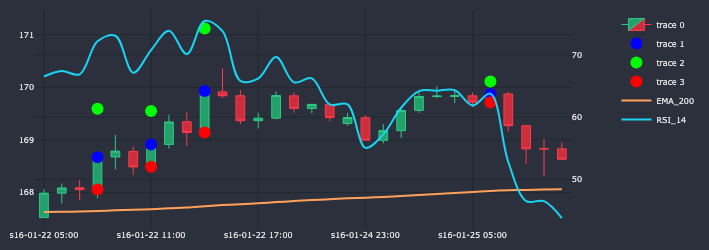

In [85]:
df_plot = df_slim.iloc[70:100]
cp = CandlePlot(df_plot, candles=True)

trades = cp.df_plot[cp.df_plot.SIGNAL != NONE]

markers = ['mid_c', 'TP', 'SL']
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

for i in range(3):
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime,
        y = trades[markers[i]],
        mode = 'markers',
        marker=dict(color=marker_colors[i], size=12)
    ))

cp.show_plot(line_traces=["EMA_200"], sec_traces=['RSI_14'], height=250)

In [84]:
df_results[df_results.SIGNAL == BUY].head()

,running,start_index,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,duration
5,False,73,168.670,169.961,1,169.5910,168.056,1.5,2016-01-22 14:00:00+00:00,2016-01-22 08:00:00+00:00,6
6,False,76,168.914,169.961,1,169.5485,168.491,1.5,2016-01-22 14:00:00+00:00,2016-01-22 11:00:00+00:00,3
7,False,79,169.932,168.996,1,171.1200,169.140,-1.0,2016-01-24 23:00:00+00:00,2016-01-22 14:00:00+00:00,9
8,False,95,169.875,169.158,1,170.1105,169.718,-1.0,2016-01-25 07:00:00+00:00,2016-01-25 06:00:00+00:00,1
9,False,101,169.218,168.538,1,170.1900,168.570,-1.0,2016-01-25 13:00:00+00:00,2016-01-25 12:00:00+00:00,1


In [76]:
class Trade:
    def __init__(self, row):
        self.running = True
        self.start_index = row.name
        self.start_price = row.mid_c
        self.trigger_price = row.mid_c
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0
        

    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price

    
    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.mid_h >= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_l)
            # if row.mid_l <= self.SL:
            #     self.close_trade(row, LOSS_FACTOR, row.mid_l)
            # elif row.mid_h >= self.TP:
            #     self.close_trade(row, PROFIT_FACTOR, row.mid_h)
        if self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_h)
            # if row.mid_h >= self.SL:
            #     self.close_trade(row, LOSS_FACTOR, row.mid_h)
            # elif row.mid_l <= self.TP:
            #     self.close_trade(row, PROFIT_FACTOR, row.mid_l)

In [77]:
open_trades = []
closed_trades = []

for index, row in df_slim.iterrows():
    for ot in open_trades:
        ot.update(row)
        if ot.running == False:
            closed_trades.append(ot)
    open_trades = [x for x in open_trades if x.running == True]

    if row.SIGNAL != NONE:
        open_trades.append(Trade(row))

In [78]:
df_results = pd.DataFrame.from_dict([vars(x) for x in closed_trades])

In [79]:
df_results.result.sum()

np.float64(259.5)

In [81]:
df_results.sort_values(by="start_index", inplace=True)